In [17]:
import numpy as np
import pandas as pd
# read
books = pd.read_csv('fiction.csv')
import string
# from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,12]
from sklearn import manifold

## word2vec

In [3]:
# from gensim.models import KeyedVectors
# filename = '/Users/weitinglin/Documents/GoogleNews-vectors-negative300.bin'
# model = KeyedVectors.load_word2vec_format(filename, binary=True)


In [4]:
def str2vec_mean(instr, placeholder = None):
    '''
    Convert string to a vector base on average vector of the composing words.
    instr: the inpput string
    placeholder: for the non-vocabularies
    '''
    # make default placeholder
    # model.vocab
    # make a place-holder: mean of three strange words
    if placeholder is None:
        ph = (model.get_vector("Ka_wai") + model.get_vector("Chief_Carla_Piluso") + model.get_vector("Marc_Andre_Bergeron"))/3
    
    # remove punctuation
    nopunc = [char for char in instr if char not in string.punctuation]
    
    # Join the characters again to form the string.
    mystr = ''.join(nopunc).split()
    
    # Remove "the", "a", "an"
    nonsense = ["the", "a", "an"]#, "and", "to","on", "from", "in", "by"]
    mystr = [word for word in mystr if word.lower() not in nonsense]
    
    # get average vector
    L =len(mystr)
    #temp = np.zeros(300)
    if (mystr[0] in model.vocab):
        temp = model.get_vector(mystr[0])
    else:
        temp = ph
        # otherwise a vector of zeros
    if (L>1):
        for l in range(1,L):
            if (mystr[l] in model.vocab):
                temp = temp + model.get_vector(mystr[l])
            else:
                temp = temp + ph    
    out = temp/L
    
    return np.array(out.tolist())


In [18]:
M = len(books) # number of examples
wordmat = np.zeros((M,300))
np.shape(wordmat)

(100, 300)

In [19]:
for m in range(M):
    A = books["title"][m]
    temp = str2vec_mean(A).tolist()
    wordmat[m,:] = temp

In [22]:

Y = manifold.MDS(n_components= 2,n_init = 100,random_state=1,dissimilarity='euclidean').fit_transform(wordmat[1:40,:])

Text(0.5,1,'Book titles on a 2D space: similar books are plotted closer on this graph')

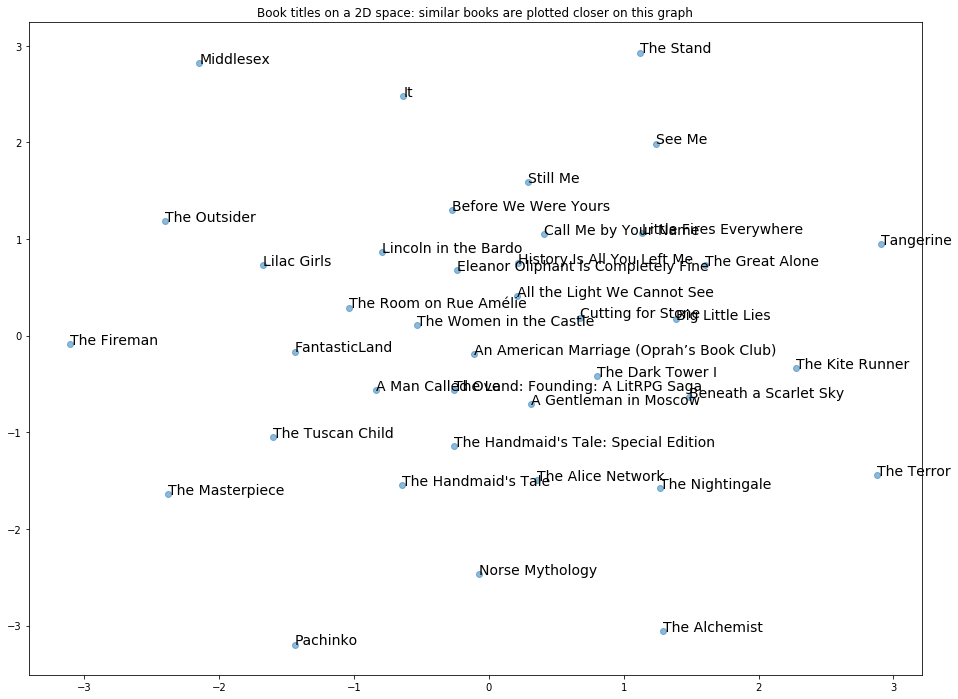

In [24]:
fig, ax = plt.subplots()
fig = plt.figure(figsize=(18, 16), dpi= 180, facecolor='w', edgecolor='k')

sc = ax.scatter(Y[:, 0], Y[:, 1], alpha= 0.5)
for i,m in enumerate(books["title"][1:40]):
    ax.annotate(m, xy=(Y[i, 0], Y[i, 1]),fontsize = 14)


# circle2 = plt.Circle((Y[L, 0], Y[L, 1]), 1, color='b', fill=False)
# ax.annotate('Book suggestions', xy=(Y[L, 0]-0.2, Y[L, 1]-0.2),fontsize = 18, color = "b")
# ax.add_artist(circle2)

    
ax.set_title("Book titles on a 2D space: similar books are plotted closer on this graph")


## search app prototype

In [26]:
from scipy.stats import rankdata

In [28]:
def fuzzy_find(mytitle, shelf, shelfmat, maxshow = 10,threshhold = 2.5):
    '''
    mytitle: the user input keyword for fuzzy search
    shelf: df with column named 'title', find book from
    maxshow: the max. number of result return.
    threshhold: threshhold of similarity for the "match"
    '''
    A = str2vec_mean(mytitle)
    dist = np.sqrt(np.sum((shelfmat-A) ** 2,axis = 1))
    fuzzy = np.where(dist < threshhold)[0]
    L = len(fuzzy)
    if L > maxshow:
        rankF = rankdata(dist, method='min')
        fuzzy = np.where(rankF <= maxshow)[0]
    return shelf["title"][fuzzy], dist[fuzzy]

In [29]:
mytitle = "Butterfly in resin"

In [30]:
(result, dist) = fuzzy_find(mytitle,books, wordmat, maxshow = 3)
result

45    The Brief Wondrous Life of Oscar Wao
48                     Dragonfly in Amber 
69           The Art of Racing in the Rain
Name: title, dtype: object

## A case of fuzzy search

In [142]:
my_key_word = 'black castle'


In [143]:
(result, dist) = fuzzy_find(mytitle, books, wordmat, maxshow = 3, threshhold = 5)


In [144]:
result





22       Lincoln in the Bardo
33    The Women in the Castle
35           The Dark Tower I
Name: title, dtype: object

## (Not so succesfule) case 3

In [40]:
mytitle = 'dark woods'

In [41]:
(result, dist) = fuzzy_find(mytitle,books, wordmat, maxshow = 10, threshhold = 5)
result

22                                 Lincoln in the Bardo
34                          All the Light We Cannot See
35                                     The Dark Tower I
42                     The Ocean at the End of the Lane
45                 The Brief Wondrous Life of Oscar Wao
48                                  Dragonfly in Amber 
60                          We Need to Talk About Kevin
69                        The Art of Racing in the Rain
71    Fizzlesprocket: Everybody Loves Large Chests -...
81                         The Adventures of Tom Sawyer
Name: title, dtype: object

## show the similar titles in a landscape

In [76]:
mytitle = 'black castle'
(result, dist) = fuzzy_find(mytitle,books, wordmat, maxshow = 20, threshhold = 10)

In [77]:
ind =  result.index

In [78]:
subset = wordmat[ind, :]

In [79]:
target_vec = str2vec_mean(mytitle)
# vector matrix
temp = np.zeros((len(ind)+1,300))
temp[0:len(ind),:] = subset
temp[-1,:] = target_vec

In [80]:
tempdb = pd.DataFrame([mytitle])
subset_title = books["title"][ind].append(tempdb)
subset_title.columns = ['title']
subset_title.head()

,title
4,An American Marriage (Oprah’s Book Club)
12,Eleanor Oliphant Is Completely Fine
22,Lincoln in the Bardo
29,The Room on Rue Amélie
30,The Land: Founding: A LitRPG Saga


In [81]:
subset_dist = np.append(dist,0) 

In [82]:

Y = manifold.MDS(n_components= 2,n_init = 100,random_state=1, dissimilarity='euclidean').fit_transform(temp)

Text(0.5,1,'Book titles on a 2D space: similar books are plotted closer on this graph')

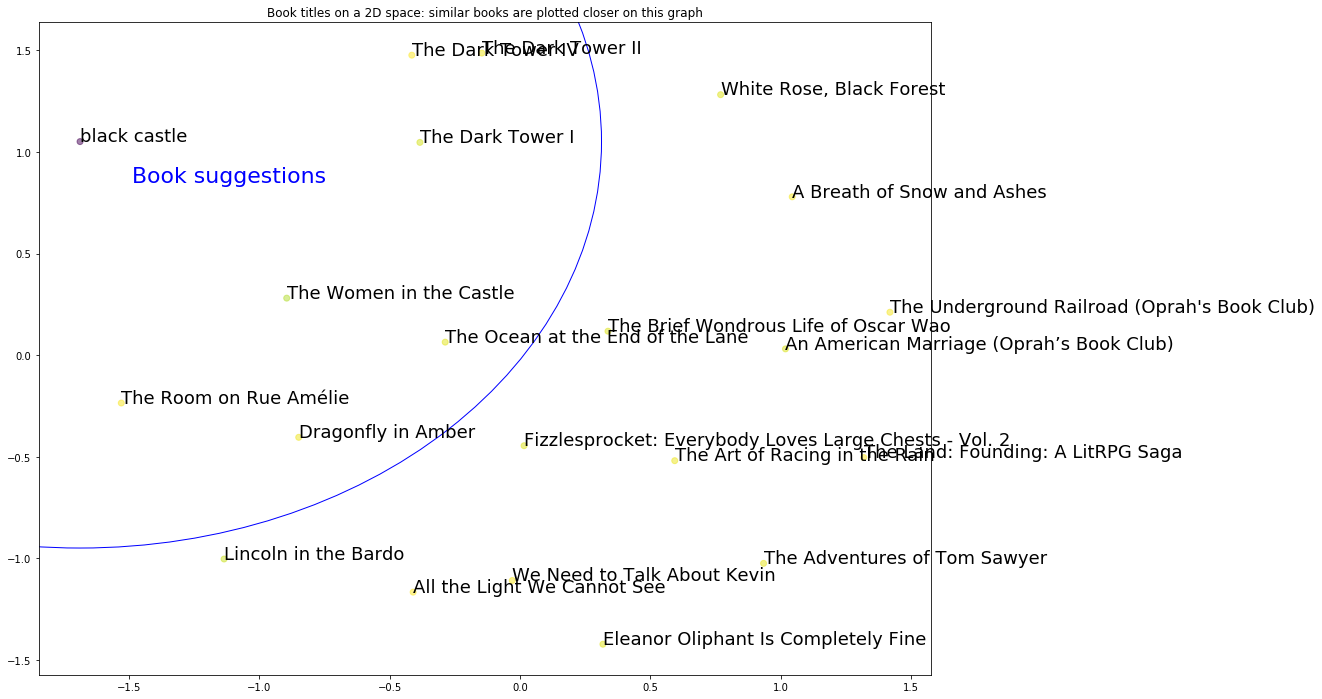

In [83]:
fig, ax = plt.subplots()
fig = plt.figure(figsize=(18, 16), dpi= 180, facecolor='w', edgecolor='k')

sc = ax.scatter(Y[:, 0], Y[:, 1], c = subset_dist,  alpha= 0.5)
for i,m in enumerate(subset_title['title']):
    ax.annotate(m, xy=(Y[i, 0], Y[i, 1]),fontsize = 18)


circle2 = plt.Circle((Y[-1, 0], Y[-1, 1]), 2, color='b', fill=False)
ax.annotate('Book suggestions', xy=(Y[-1, 0]+0.2, Y[-1, 1]-0.2),fontsize = 22, color = "b")
ax.add_artist(circle2)

    
ax.set_title("Book titles on a 2D space: similar books are plotted closer on this graph")

## Next: a better string--> vector (or matrix) encoding

In [87]:
min(wordmat[1,:])

-0.4140625

In [90]:
## 1. string to mat
Limit = 5
sheet = np.ones((300, 10))* 2 # 2 as the placeholder

In [92]:
books['mat'] = [1 for i in books['title']]

In [101]:
books.head()


,Unnamed: 0,title,mat
0,0,Pet Sematary,1
1,1,The Great Alone,1
2,2,Before We Were Yours,1
3,3,Little Fires Everywhere,1
4,4,An American Marriage (Oprah’s Book Club),1


In [124]:
def str2mat(instr, limit = 5, placeholder = None):
    '''
    Convert string to a vector base on average vector of the composing words.
    instr: the inpput string
    placeholder: for the non-vocabularies
    '''
    # make default placeholder
    # model.vocab
    # make a place-holder: mean of three strange words
    if placeholder is None:
        ph = (model.get_vector("Ka_wai") + model.get_vector("Chief_Carla_Piluso") + model.get_vector("Marc_Andre_Bergeron"))/5
    
    # remove punctuation
    nopunc = [char for char in instr if char not in string.punctuation]
    
    # Join the characters again to form the string.
    mystr = ''.join(nopunc).split()
    
    # Remove "the", "a", "an"
    nonsense = ["the", "a", "an"]#, "and", "to","on", "from", "in", "by"]
    mystr = [word for word in mystr if word.lower() not in nonsense]
    
    # get average vector
    L = min(len(mystr), limit) # number of words
    #temp = np.zeros(300)
    
    ## padding up
    sheet = np.ones((300, limit))* 2 
    for l in range(L):
        if (mystr[l] in model.vocab):
            sheet[:,l] = model.get_vector(mystr[l])
        else:
            sheet[:,l] = ph
  
    return L, sheet


In [125]:
str2mat('dark ojsoi')

(2, array([[ 1.21093750e-01,  1.95312500e-03,  2.00000000e+00,
          2.00000000e+00,  2.00000000e+00],
        [ 1.45507812e-01, -3.82812507e-02,  2.00000000e+00,
          2.00000000e+00,  2.00000000e+00],
        [ 1.45507812e-01, -6.61254898e-02,  2.00000000e+00,
          2.00000000e+00,  2.00000000e+00],
        ...,
        [ 4.24804688e-02, -6.67480454e-02,  2.00000000e+00,
          2.00000000e+00,  2.00000000e+00],
        [ 1.67968750e-01, -8.07617158e-02,  2.00000000e+00,
          2.00000000e+00,  2.00000000e+00],
        [ 1.68945312e-01,  3.71093745e-03,  2.00000000e+00,
          2.00000000e+00,  2.00000000e+00]]))

In [126]:
books['length'] = [str2mat(i)[0] for i in books['title']]

In [128]:
books['mat'] = [str2mat(i)[1] for i in books['title']]

In [129]:
books.head()

,Unnamed: 0,title,mat,length
0,0,Pet Sematary,"[[-0.0341796875, 0.001953125, 2.0, 2.0, 2.0], ...",2
1,1,The Great Alone,"[[0.060546875, 0.19140625, 2.0, 2.0, 2.0], [0....",2
2,2,Before We Were Yours,"[[-0.005035400390625, -0.2890625, 0.142578125,...",4
3,3,Little Fires Everywhere,"[[-0.09716796875, 0.703125, 0.031494140625, 2....",3
4,4,An American Marriage (Oprah’s Book Club),"[[0.00775146484375, 0.0673828125, 0.001953125,...",5


## mat compare